# Analysis of Photoplethysmography (PPG) Signal 

## Functions: 

1.   **PPG_2pulse** - calculate an estimation of pulse out of PPG data 
2.   **SNR** - calculate SNR ratio for a given signal
3.   **activity_type** - machine learning regression of activity type (rest, walk or run) out of accelerometer data 
4.   **find_peaks** - find peak in time series data 
5.   **bp_filter** - implemenation of band bapss filter



In [5]:
from google.colab import drive
import scipy
from scipy.io import loadmat
from scipy import signal
from scipy import sparse
from scipy.sparse.linalg import spsolve

import numpy as np
import pandas as pd
from math import sqrt

import matplotlib.pyplot as plt
import re, seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


from sklearn import model_selection, ensemble, linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ElasticNetCV 
from sklearn.svm import SVR

# Load & explore data

In [6]:
# paths and constants 

data_path = '/content/drive/MyDrive/Colab Notebooks/Data_DSP.mat'

times = {
    'first_rest': [0, 600], 
    'walk': [601, 1320], 
    'run': [1321, 2500], 
    'scnd_rest': [2501, 3114]
         }
Fs = 10
srate = 100 
minute = 60 * Fs
title_font = 16

In [7]:
drive.mount('/content/drive')
dsp_data = loadmat(data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
dsp_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Acc1', 'Acc2', 'Acc3', 'Pulse'])

In [9]:
df = pd.DataFrame(np.hstack(( dsp_data['Pulse'], dsp_data['Acc1'], dsp_data['Acc2'], dsp_data['Acc3'])))
df.columns =['Pulse', 'Acc1', 'Acc2', 'Acc3']
df

,Pulse,Acc1,Acc2,Acc3
0,143403,125,191,24
1,143356,123,185,31
2,143297,118,191,27
3,143379,116,178,19
4,143459,157,160,10
...,...,...,...,...
3110,143163,-19,223,-46
3111,143230,-14,229,-44
3112,143273,-11,235,-47
3113,143305,-3,231,-41


#1: PPG_2pulse 
## calculate an estimation of pulse out of PPG data 

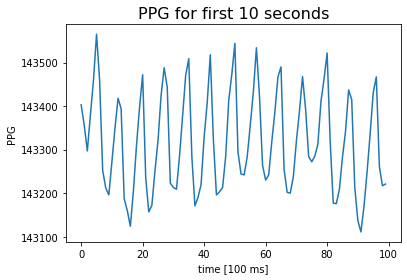

In [10]:
plt.plot(dsp_data['Pulse'][0:100])
plt.xlabel('time [100 ms]')
plt.ylabel('PPG')
plt.title("PPG for first 10 seconds", fontsize=title_font)
plt.show()

☝ We can easily count the peaks - it's 13 for 10 seconds. One way to solve the PPG to pulse problem can be analysing the peaks as they are told to represent the systolic peak. 

We can also use a regression learning algorithm, where PPG for a few seconds is the X and pulse for this time is the Y (see [Time series regression models](https://otexts.com/fpp2/regression.html) chapter).

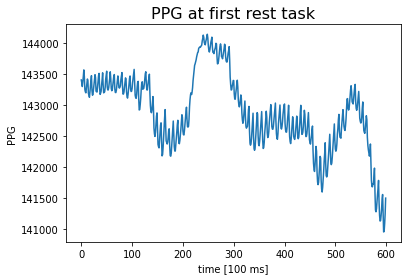

In [11]:
plt.plot(dsp_data['Pulse'][times['first_rest'][0]: times['first_rest'][1]])
plt.xlabel('time [100 ms]')
plt.ylabel('PPG')
plt.title("PPG at first rest task", fontsize=title_font)
plt.show()

☝ I will implement the first and more reasobanle method of peak analysis. It is important to see there are low frequncy waves that interfere with the data. Therefore before thresholding and finding the peaks, I will preform a cleaning step. 

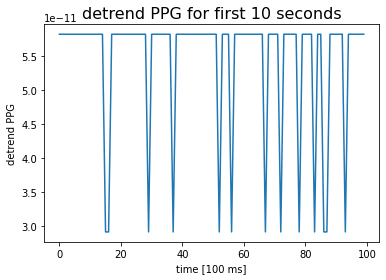

In [12]:
ppg = dsp_data['Pulse']
ppg_detrend = signal.detrend(ppg, type='linear')

plt.plot(ppg_detrend[0:100])
plt.xlabel('time [100 ms]')
plt.ylabel('detrend PPG')
plt.title("detrend PPG for first 10 seconds", fontsize=title_font)
plt.show()

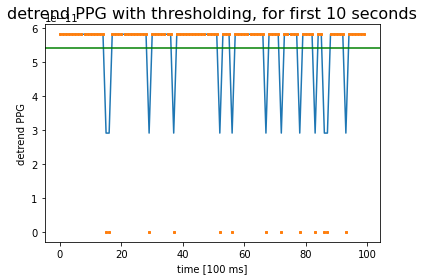

In [13]:
data_mean = np.mean(ppg_detrend)
max_data = ((ppg_detrend - data_mean) > 0)
plt.plot(ppg_detrend[0:100])
plt.plot(max_data[0:100] * ppg_detrend[0:100], 's',markersize=2)
plt.axhline(y=data_mean, color='g', linestyle='-')
plt.xlabel('time [100 ms]')
plt.ylabel('detrend PPG')
plt.title("detrend PPG with thresholding, for first 10 seconds", fontsize=title_font)
plt.show()

In [14]:
max_data_idx = [i for i, x in enumerate(max_data) if x]
peaks_idx = [i for i, t in enumerate(zip(max_data_idx,max_data_idx[1:])) if ((t[1] - t[0]) > 1)]
peaks = np.zeros(len(ppg))
for i in range(len(ppg)):
  if (i in peaks_idx):
    peaks[i] = 1 

first_rest = peaks[times['first_rest'][0]: times['first_rest'][1]]
print('estimated pulse for first rest (BPM) = ', sum(first_rest)/((len(first_rest)/minute)))

estimated pulse for first rest (BPM) =  100.0


☝ we can see that this is higher that the information given. It can be becuase of the detrendig process and\or the peak thresholding.

In [15]:
pulse = []
for i in range(0, len(peaks)-Fs, Fs):
  pulse = pulse + [sum(peaks[i:i+Fs])]
# pulse is defined as BPM beats per minute, for this assigmnet the pulse is per second.  

☝ now let's rap it all with a function: 

In [16]:
def PPG_2pulse(ppg):
  ppg_detrend = signal.detrend(ppg, type='linear')
  data_mean = np.mean(ppg_detrend)
  max_data = ((ppg_detrend - data_mean) > 0)
  max_data_idx = [i for i, x in enumerate(max_data) if x]
  peaks_idx = [i for i, t in enumerate(zip(max_data_idx,max_data_idx[1:])) if ((t[1] - t[0]) > 1)]
  peaks = np.zeros(len(ppg))
  for i in range(len(ppg)):
    if (i in peaks_idx):
      peaks[i] = 1
    pulse = []
    for i in range(0, len(peaks)-Fs, Fs):
      pulse = pulse + [sum(peaks[i:i+Fs])]
    return pulse

# 2: SNR
## calculate SNR ratio for a given signal

☝ I use a unitless definition of SNR as the amplitude of the signal divided by the amplitude of the noise. 

In [17]:
def SNR(ppg):
  pulse = PPG_2pulse(ppg)
  noise = ppg - pulse
  a_noise = np.ptp(noise)
  a_signal = np.ptp(pulse)
  return a_signal / a_noise

#3: detect activity type

In [18]:
X = df[['Acc1','Acc2', 'Acc3']]

In [19]:
def add_line(plt, y, txt):
  plt.axhline(y=y, color='w', linestyle='-')
  plt.text(0.8, y-150, txt, color="w",ha="right", va="center")

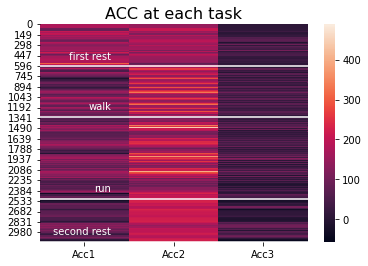

In [20]:
sns.heatmap(X)
add_line(plt, times['first_rest'][1], 'first rest')
add_line(plt, times['walk'][1], 'walk')
add_line(plt, times['run'][1], 'run')
add_line(plt, times['scnd_rest'][1], 'second rest')
plt.title("ACC at each task", fontsize=title_font)
plt.show()

☝ We can see that there is a linear trend, where the ACC data gets higher values as the task is more active. Therefore the learning algorithm can be regression (and not classification). 

Because of the structure of the data, I continued without feature engeneering and scaling. 

In [21]:
rest = [1]
walk = [2]
run = [3]

df['Y'] = rest * (times['first_rest'][1] - times['first_rest'][0] + 1) + walk * (times['walk'][1] - times['walk'][0] + 1) + run * (times['run'][1] - times['run'][0] + 1) + rest * (times['scnd_rest'][1] - times['scnd_rest'][0] + 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


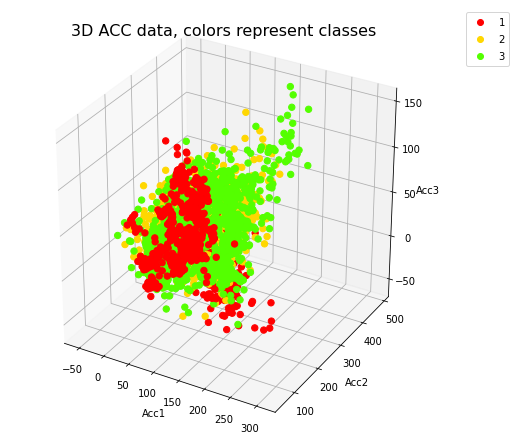

In [22]:
x = df['Acc1']
y = df['Acc2']
z = df['Acc3']

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
fig.add_axes(ax)

sc = ax.scatter(x, y, z, s=40, c=df['Y'], marker='o', cmap='prism', alpha=1)
ax.set_xlabel('Acc1')
ax.set_ylabel('Acc2')
ax.set_zlabel('Acc3')

plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title('3D ACC data, colors represent classes', fontsize=title_font)
plt.show()

In [23]:
X = df[['Acc1', 'Acc2', 'Acc3']].values
y = df['Y'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=101)

In [24]:
regressors = [
    linear_model.Lasso(alpha=0.1),
    linear_model.LinearRegression(),
    ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
       normalize=False, positive=False, precompute='auto', random_state=0,
       selection='cyclic', tol=0.0001, verbose=0),
    SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False),
    linear_model.Ridge(alpha=.5)                
    ]
for regressor in regressors:
    model = regressor
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test)
    print(regressor)
    print("mean squared error: %.3f" % sqrt(mean_squared_error(y_test, y_pred)))
    print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

Lasso(alpha=0.1)
mean squared error: 0.868
Coefficient of determination: 0.02
LinearRegression()
mean squared error: 0.868
Coefficient of determination: 0.02
ElasticNetCV(cv=5, normalize=False, random_state=0)
mean squared error: 0.868
Coefficient of determination: 0.02


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


SVR()
mean squared error: 0.697
Coefficient of determination: 0.37
Ridge(alpha=0.5)
mean squared error: 0.868
Coefficient of determination: 0.02


☝ These regression models were not so good. However I checked also gradient boosting regressor for feature improtance, and it happend to be better: 

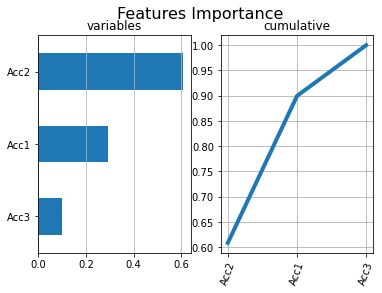

Mean squared error: 0.21
Coefficient of determination: 0.73


In [25]:
model = ensemble.GradientBoostingRegressor()
model.fit(X_test,y_test)

feature_names = ['Acc1', 'Acc2', 'Acc3']
importances = model.feature_importances_
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, 
            "VARIABLE":feature_names}).sort_values("IMPORTANCE", 
            ascending=False)
dtf_importances['cumsum'] =  dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=title_font)
ax[0].title.set_text('variables')
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, 
                                 legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), 
          xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

y_pred = model.predict(X_test)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

☝ Interesting to see that most of the data can be extracted only from one accelerometer source. It's a clue to do PCA and make each source independent. 

In [26]:
def activity_type(data, model=model):
  return model.predict(data)

# 4: find peaks 

In [27]:
def findpeaks2(x, MinDistance, MinHeight):
  x_prv = [np.inf] + x[:-1]
  x_pst = x[1:] + [np.inf]
  raw_peaks = [[i, x[i]] for i in range(len(x)) if ((x[i] > x_prv[i]) and (x[i] > x_pst[i]))]
  raw_peaks = np.matrix(raw_peaks)
  high_peaks = raw_peaks[:,1] >= MinHeight
  high_peaks_idx = np.multiply(high_peaks, raw_peaks[:,0])
  pad = [0] * MinDistance
  peaks_pad = pad + [a.item() for a in high_peaks_idx] + pad
  peaks_idx = [peaks_pad[i] for i in range(1, len(peaks_pad)-1) if 
             ((((abs(peaks_pad[i] - peaks_pad[i-1])) >= MinDistance) 
             and (abs(peaks_pad[i] - peaks_pad[i+1])) >= MinDistance) 
             and peaks_pad[i] > 0)]  
  return peaks_idx

In [28]:
x = df['Pulse'][1:100].values.tolist()
MinHeight = np.mean(x)
MinDistance = 3
peaks = findpeaks2(x, MinDistance, MinHeight)
print(peaks)

[4, 11, 19, 26, 34, 41, 49, 56, 64, 71, 79, 86, 95]


Text(0.5, 1.0, 'Peaks markded in pulse data')

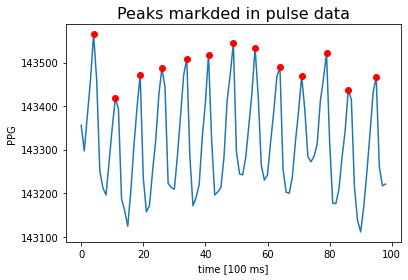

In [29]:
plt.plot(x)
hights = [x[i] for i in peaks]
plt.plot(peaks, hights, 'or')
plt.xlabel('time [100 ms]')
plt.ylabel('PPG')
plt.title('Peaks markded in pulse data', fontsize=title_font)

☝  I marked the peaks found by the function.

# 5: band pass filter 

In [30]:
b, a = signal.butter(2, [0.5/(20/2), 5/(20/2)], 'bandpass')
data = df['Pulse'][1:1000].values.tolist()

In [31]:
def my_pbf(data, a, b):
  N = len(data)
  f_data = [0] * N
  for n in range (4, N):
    f_data[n] = a[0] * data[n] + a[1] * data[n-1] + a[2] * data[n-2] 
    + a[3] * data[n-3] + a[4] * data[n-4] 
    + b[1] * f_data[n-1] + b[2] * f_data[n-2] 
    + b[3] * f_data[n-3] + b[4] * f_data[n-4]
  return f_data

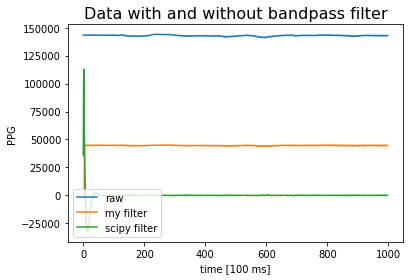

In [34]:
f_data = my_pbf(data, a, b)
plt.plot(data)
plt.plot(f_data)
y = signal.lfilter(b, a, data)
plt.plot(y)
plt.xlabel('time [100 ms]')
plt.ylabel('PPG')
plt.title('Data with and without bandpass filter', fontsize=title_font)
plt.legend(['raw', 'my filter', 'scipy filter'])